### Necessary imports

In [1]:
##necessary imports
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### Dataset description  

The dataset consists of cell identity metadata and measurements of cell shape, position and movement.  

**Column descriptions:** 

'Unnamed: 0' -- index column  
'Track ID_x' -- tracklet ID from automatic result dataframe -- DON'T USE THIS! It's used for tracking accuracy calculations  
'Track ID_y' -- USE THIS! Track ID_y -- Tracklet ID as string  
'Spot frame' -- frame number  
't' -- time in frames (same as 'Spot frame', but I'm including both because I have code using both columns...)  
't_hours' -- experiment actual time in hours  
'POSITION_X' -- spot centroid coordinates in µm  
'POSITION_Y' -- spot centroid coordinates in µm  
'POSITION_Z' -- spot centroid coordinates in µm  
'X_orig' -- spot centroid coordinates in pixels  
'Y_orig' -- spot centroid coordinates in pixels  
'Z_orig' -- spot centroid coordinates in pixels  
'TrackMate Track ID' -- track ID from automatic result dataframe -- DON'T USE THIS!  
'Generation ID' -- generation 0 means 0 divisions in cell lineage, generation 1 is after 1 division in lineage, etc.  
'Tracklet Number ID' -- number of tracklet in track lineage  
'Track Duration' -- Track duration in frames  
'nuc_label' -- nucleus label integer value  
'Spot track ID relabelled' -- Track ID for whole lineage, tracks consist of multiple tracklets, and new tracklets are formed when a cell divides  
'Track ID numeric' -- Tracklet ID converted to numeric value  
'cell_type' -- cell type according to last timepoint (annotated manually) however, if tracking is automated, this can contain errors (see 'annotation' column!)  
'annotation' -- 'manual' means track has been annotated completely for as long as the cell can be followed, 'automatic' means the spot has been tracked by TrackMate, and thus cell lineage can contain errors  
'Local_Cell_Density' -- amount of cells within a 70 px radius of cell centroid  
'Speed' -- object displacement in dT (calculated from previous spot in tracklet)  
'Motion_Angle_Z' -- angle of motion (calculated from previous spot in tracklet)  
'Motion_Angle_Y' -- angle of motion (calculated from previous spot in tracklet)  
'Motion_Angle_X' -- angle of motion (calculated from previous spot in tracklet)  
'Acceleration' -- d(speed) in dT (calculated from previous spot in tracklet)  
'Distance_Cell_mask' -- distance (in pixels) to closest tissue edge  
'Radial_Angle_Z' -- cell centroid Z angle compared to tissue centroid Z  
'Radial_Angle_Y' -- cell centroid Y angle compared to tissue centroid Y  
'Radial_Angle_X' -- cell centroid X angle compared to tissue centroid X  
'MSD' -- mean square displacement of track until spot timepoint  
'nuc_Radius' -- radius of a fit sphere  
'nuc_Eccentricity_Comp_First' -- object 1st order eccentricity, i.e. length  
'nuc_Eccentricity_Comp_Second' -- object 2nd order eccentricity, i.e. width  
'nuc_Eccentricity_Comp_Third' -- object 3rd order eccentricity, i.e. height  
'nuc_Surface_Area' -- surface area of marching cubes algorithm calculated surface mesh  
'nuc_Cell_Axis_Z' -- angle between tissue Z axis and cell's 3rd order eigenvector  
'nuc_Cell_Axis_Y' -- angle between tissue Y axis and cell's 2nd order eigenvector  
'nuc_Cell_Axis_X' -- angle between tissue X axis and cell's 1st order eigenvector  
'mem_...' -- same shape features as nuclei, but calculated for associated membrane object  
'mem_2d_area' -- area of center slice of associated membrane object  
'mem_2d_perimeter' -- perimeter of center slice of associated membrane object  
'mem_2d_eccentricity' -- eccentricity of center slice of associated membrane object  
'mem_2d_solidity' -- solidity of center slice of associated membrane object  
'mem_2d_extent' -- extent of center slice of associated membrane object  
'mem_2d_axis_major_length' -- major axis length of center slice of associated membrane object  
'mem_2d_axis_minor_length' -- minor axis length of center slice of associated membrane object  
'mem_2d_feret_diameter_max' -- longest Feret's diameter of center slice of associated membrane object  
'mem_latent_feature_...' -- latent features calculated for associated membrane object  

### Data pre-processing

In [2]:
#Data normalization function
def normalize_dataframe(df, columns_to_normalize):
    # Create a copy of the dataframe
    df_normalized = df.copy()

    # Replace missing values with 0 in the selected columns
    #df_normalized[columns_to_normalize] = df_normalized[columns_to_normalize].fillna(0)

    # Normalize selected columns
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df_normalized[columns_to_normalize].values)
    df_normalized[columns_to_normalize] = scaled_values

    return df_normalized

In [243]:
#use gdown to download the example files from my Google Drive (I will come up with another solution for this!)

#!pip install gdown

!gdown "https://drive.google.com/uc?id=1XG7kdhzahwe23fEwQ564vUALqi6NEqvC"
!gdown "https://drive.google.com/uc?id=1GGWCGxArEgHM2oH6TC7WCHoFtsLwLAZ9"

'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.
Downloading...
From (original): https://drive.google.com/uc?id=1XG7kdhzahwe23fEwQ564vUALqi6NEqvC
From (redirected): https://drive.google.com/uc?id=1XG7kdhzahwe23fEwQ564vUALqi6NEqvC&confirm=t&uuid=921e89ee-6687-419b-9ed5-614b35bd0ac8
To: d:\CopenhagenWorkflow-main\full_manual_dataset.csv

  0%|          | 0.00/946M [00:00<?, ?B/s]
  0%|          | 2.62M/946M [00:00<00:36, 26.0MB/s]
  1%|          | 9.44M/946M [00:00<00:18, 50.4MB/s]
  2%|▏         | 17.3M/946M [00:00<00:14, 62.9MB/s]
  3%|▎         | 25.2M/946M [00:00<00:13, 68.6MB/s]
  3%|▎         | 33.0M/946M [00:00<00:12, 71.4MB/s]
  4%|▍         | 40.9M/946M [00:00<00:12, 72.6MB/s]
  5%|▌         | 48.8M/946M [00:00<00:12, 73.8MB/s]
  6%|▌         | 56.6M/946M [00:00<00:11, 74.9MB/s]
  7%|▋         | 64.5M/946M [00:00<00:11, 75.6MB/s]
  8%|▊         | 72.4M/946M [00:01<00:11, 76.3MB/s]
  8%|▊         | 80.2M/946M [00:01<00:11, 76.3MB/s]
 

In [244]:
#Reading in full dataset which contains manual annotations of tracks

full_df = pd.read_csv("./full_manual_dataset.csv")

In [ ]:
#Reading in full dataset which only contains automated annotations of tracks 
# -- the automated tracking information is then used to assign trackwise-prediction labels
full_auto_df = pd.read_csv("./full_automated_tracks.csv")

full_auto_df = full_auto_df[['Spot frame', 
                             'Spot track ID relabelled',
                             'Track ID',
                             'nuc_label']]

full_auto_df.rename(columns={'Spot track ID relabelled' : 'Spot track ID relabelled_auto',
 'Track ID' : 'Track ID_auto'}, inplace=True)

In [5]:
#Merge in the automated tracking information to full_df
#Merging is done by Spot frame (time information) and nucleus label, 
# this combination should be unique for each cell

full_df_merged = pd.merge(full_df, full_auto_df, on=['Spot frame', 'nuc_label'], how='left')

In [6]:
#Use only features which don't cross-correlate (Pearson correlation value < 0.9)
#The array has been defined earlier, just pasted here

selected_features = ['Local_Cell_Density',
 'Speed',
 'Motion_Angle_Z',
 'Motion_Angle_Y',
 'Motion_Angle_X',
 'Acceleration',
 'Distance_Cell_mask',
 'Radial_Angle_Z',
 'MSD',
 'nuc_Radius',
 'nuc_Eccentricity_Comp_First',
 'nuc_Eccentricity_Comp_Second',
 'nuc_Eccentricity_Comp_Third',
 'nuc_Cell_Axis_Z',
 'mem_Radius',
 'mem_Eccentricity_Comp_First',
 'mem_Eccentricity_Comp_Second',
 'mem_Eccentricity_Comp_Third',
 'mem_Surface_Area',
 'mem_Cell_Axis_Z',
 'mem_Radial_Angle_Z',
 'mem_2d_area',
 'mem_2d_eccentricity',
 'mem_2d_solidity',
 'mem_2d_extent',
 'mem_latent_feature_0',
 'mem_latent_feature_1',
 'mem_latent_feature_2',
 'mem_latent_feature_3',
 'mem_latent_feature_4',
 'mem_latent_feature_5',
 'mem_latent_feature_6',
 'mem_latent_feature_7',
 'mem_latent_feature_8',
 'mem_latent_feature_9',
 'mem_latent_feature_10',
 'mem_latent_feature_11',
 'mem_latent_feature_12',
 'mem_latent_feature_13',
 'mem_latent_feature_14',
 'mem_latent_feature_15',
 'mem_latent_feature_16',
 'mem_latent_feature_17',
 'mem_latent_feature_18',
 'mem_latent_feature_19',
 'mem_latent_feature_20',
 'mem_latent_feature_21',
 'mem_latent_feature_22',
 'mem_latent_feature_23',
 'mem_latent_feature_24',
 'mem_latent_feature_25',
 'mem_latent_feature_26',
 'mem_latent_feature_27',
 'mem_latent_feature_28',
 'mem_latent_feature_29',
 'mem_latent_feature_30',
 'mem_latent_feature_31',
 'mem_latent_feature_32',
 'mem_latent_feature_33',
 'mem_latent_feature_34',
 'mem_latent_feature_35',
 'mem_latent_feature_36',
 'mem_latent_feature_37',
 'mem_latent_feature_38',
 'mem_latent_feature_39',
 'mem_latent_feature_40',
 'mem_latent_feature_41',
 'mem_latent_feature_42',
 'mem_latent_feature_43',
 'mem_latent_feature_44',
 'mem_latent_feature_45',
 'mem_latent_feature_46',
 'mem_latent_feature_47',
 'mem_latent_feature_48',
 'mem_latent_feature_49',
 'mem_latent_feature_50',
 'mem_latent_feature_51',
 'mem_latent_feature_52',
 'mem_latent_feature_53',
 'mem_latent_feature_54',
 'mem_latent_feature_55',
 'mem_latent_feature_56',
 'mem_latent_feature_57',
 'mem_latent_feature_58',
 'mem_latent_feature_59',
 'mem_latent_feature_60',
 'mem_latent_feature_61',
 'mem_latent_feature_62',
 'mem_latent_feature_63']

In [7]:
# The features are z normalized for training
train_df_full = normalize_dataframe(full_df_merged, selected_features)

In [8]:
# Latent features will not be used in categorization
selected_non_latent = [feature for feature in selected_features if 'latent' not in feature]

In [9]:
# Keep only useful columns and drop rows which have NaN values in the columns of interest
train_df = train_df_full.loc[:,['Spot track ID relabelled', 'Spot track ID relabelled_auto', 'Track ID_y', 'Track ID_auto', 't_hours', 'cell_type', 'annotation'] + selected_non_latent].dropna(subset=selected_non_latent)

In [10]:
train_df_full

,Unnamed: 0.1,Unnamed: 0,Track ID_x,Track ID_y,Spot frame,t,t_hours,POSITION_X,POSITION_Y,POSITION_Z,...,mem_latent_feature_56,mem_latent_feature_57,mem_latent_feature_58,mem_latent_feature_59,mem_latent_feature_60,mem_latent_feature_61,mem_latent_feature_62,mem_latent_feature_63,Spot track ID relabelled_auto,Track ID_auto
0,0,52690.0,19700.0,0,2,2.0,0.082778,643.314163,570.297245,20.057663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159,15900
1,1,52695.0,19700.0,0,3,3.0,0.124167,641.483249,570.000200,20.160878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159,15900
2,2,52710.0,19700.0,0,4,4.0,0.165556,641.585796,569.708138,19.637076,...,-0.819834,-1.193935,0.087203,-2.501723,0.228554,2.890973,0.401488,-1.974894,159,15900
3,3,52693.0,19700.0,0,5,5.0,0.206944,642.880597,568.702730,19.895262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159,15900
4,4,52688.0,19700.0,0,6,6.0,0.248333,643.062147,569.922801,19.888730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159,15900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745613,745431,259489.0,103100.0,322800,271,271.0,14.799722,553.922084,1092.088025,17.453814,...,-0.298383,0.863265,0.568527,1.301034,0.232505,-0.345389,1.171479,-0.094330,11260,1126000
745614,745432,652909.0,381700.0,480700,309,309.0,17.955833,251.592828,1043.406060,14.730466,...,0.893023,1.977464,0.027498,0.910129,2.797999,-0.341817,-0.913919,0.685688,13778,1377800
745615,745433,628791.0,344700.0,151600,328,328.0,19.533889,1292.172575,920.910393,14.182999,...,-0.277909,0.072800,-0.347319,0.305061,0.614348,0.868637,-0.311718,0.832698,11983,1198300
745616,745434,NaN,NaN,408200,342,NaN,20.696667,1016.488204,960.520142,13.972160,...,-1.372637,1.462170,-0.689744,0.837299,-0.413925,0.772694,-0.238319,1.761301,15898,1589800


In [11]:
train_df

,Spot track ID relabelled,Spot track ID relabelled_auto,Track ID_y,Track ID_auto,t_hours,cell_type,annotation,Local_Cell_Density,Speed,Motion_Angle_Z,...,mem_Eccentricity_Comp_First,mem_Eccentricity_Comp_Second,mem_Eccentricity_Comp_Third,mem_Surface_Area,mem_Cell_Axis_Z,mem_Radial_Angle_Z,mem_2d_area,mem_2d_eccentricity,mem_2d_solidity,mem_2d_extent
1,0,159,0,15900,0.124167,unknown,automatic,-1.740082,0.557421,-0.188206,...,1.272627,0.997179,3.091568,1.461602,2.367644,-0.501916,0.577530,0.546173,-0.215314,-0.521946
2,0,159,0,15900,0.165556,unknown,automatic,-1.723737,-0.614436,3.098849,...,0.704866,0.654569,1.561619,0.819498,1.776373,-0.997624,0.338940,0.648333,-1.653080,-1.189350
6,0,159,0,15900,0.331111,unknown,automatic,-1.756428,0.281884,-0.260346,...,1.771002,0.178921,2.370799,1.249265,2.793233,-0.325825,0.631914,1.274606,-1.057255,-0.791519
7,0,159,0,15900,0.372500,unknown,automatic,-1.740082,0.017191,1.045694,...,1.521229,0.274066,2.345600,1.185462,2.763803,-0.346527,0.577530,1.268335,-0.949041,-0.618946
8,0,159,0,15900,0.413889,unknown,automatic,-1.756428,-0.254807,1.092414,...,1.488783,0.511969,3.164575,1.304984,2.914802,-0.522642,0.440691,1.234977,-1.051288,-0.610397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745611,4624,6357,462400,635700,12.889444,unknown,automatic,0.368501,0.950337,-3.141788,...,-0.352621,-1.284512,-1.161243,-0.823729,-0.303834,0.787198,-0.711909,0.872715,-1.339603,-1.336822
745612,112,8924,11200,892400,13.221667,mcc,automatic,1.447311,-0.749198,-1.167004,...,-0.670032,-0.866533,0.838821,-0.726120,-0.590817,0.470722,-0.775065,0.514732,0.906807,-0.133728
745613,3228,11260,322800,1126000,14.799722,basal,automatic,0.205045,0.164725,-0.034417,...,2.426381,1.429643,-0.240852,2.633671,-1.001364,-0.194159,2.395025,1.093748,-2.357571,-1.412769
745614,4807,13778,480700,1377800,17.955833,unknown,automatic,-0.726655,0.265390,-0.169499,...,2.414919,1.192189,2.135797,2.386514,1.567484,0.568486,1.152953,0.825779,0.346584,-0.414676


Note: NaN dropping eliminates ~230,000 rows from the originally ~750,000 row dataset.  
The lack of feature quantifications is due to cell missing either a nucleus segmentation, a membrane segmentation or track information

In [154]:
# Keep only useful columns and drop rows which have NaN values in the columns of interest
# On top of that, make a copy of the dataframe which contains only known cell types
train_df2 = train_df_full.loc[(train_df_full['cell_type'] != 'unknown'),['Spot track ID relabelled', 'Spot track ID relabelled_auto', 'Track ID_y', 'Track ID_auto', 't_hours', 'cell_type', 'annotation'] + selected_non_latent].dropna()

In [155]:
train_df2

,Spot track ID relabelled,Spot track ID relabelled_auto,Track ID_y,Track ID_auto,t_hours,cell_type,annotation,Local_Cell_Density,Speed,Motion_Angle_Z,...,mem_Eccentricity_Comp_First,mem_Eccentricity_Comp_Second,mem_Eccentricity_Comp_Third,mem_Surface_Area,mem_Cell_Axis_Z,mem_Radial_Angle_Z,mem_2d_area,mem_2d_eccentricity,mem_2d_solidity,mem_2d_extent
26,1,709,100,70900,1.117500,basal,manual,-0.824728,-1.185150,-4.746482,...,-1.651166,-1.233762,1.084934,-1.323335,5.043013,0.249940,-1.625920,-2.579317,0.519878,1.436749
27,1,709,100,70900,1.158889,basal,manual,-0.759346,2.257107,1.973369,...,-1.220975,-0.951672,1.211041,-1.050634,4.221166,0.292683,-1.373295,-1.451629,0.383825,1.745661
29,1,709,100,70900,1.200278,basal,manual,-0.710309,0.961900,1.866890,...,-1.176560,-0.618150,1.193852,-0.919121,4.112047,0.328267,-1.168037,-1.542974,0.363243,1.078488
31,1,709,100,70900,1.241667,basal,manual,-0.759346,-0.434554,0.565579,...,0.170559,-0.162969,-1.021987,-0.000587,-0.883375,-0.149077,0.117893,0.294306,-0.811336,-0.072012
33,1,709,100,70900,1.283056,basal,manual,-0.710309,1.817496,-0.029670,...,-1.011236,-0.471439,1.009741,-0.839359,4.777751,0.649784,-1.220668,0.137111,0.592701,1.296039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745545,13688,13586,1368800,1358600,22.108611,basal,automatic,0.842524,-0.559415,1.269948,...,0.248113,0.404814,0.817581,0.307422,-0.426276,1.516817,0.435428,0.138033,0.531523,-0.217960
745608,38,944,3800,94411,10.563889,mcc,automatic,0.482920,0.723161,-0.355555,...,-0.187515,1.121912,1.868961,0.344600,3.287556,0.721560,-0.245255,-0.940320,0.666885,1.178924
745612,112,8924,11200,892400,13.221667,mcc,automatic,1.447311,-0.749198,-1.167004,...,-0.670032,-0.866533,0.838821,-0.726120,-0.590817,0.470722,-0.775065,0.514732,0.906807,-0.133728
745613,3228,11260,322800,1126000,14.799722,basal,automatic,0.205045,0.164725,-0.034417,...,2.426381,1.429643,-0.240852,2.633671,-1.001364,-0.194159,2.395025,1.093748,-2.357571,-1.412769


Note: Dropping 'unknown' cell_type rows eliminates further ~190,000 rows from the originally ~490,000 row dataset.  
The cell_type annotation is based on the final timepoint cell type in the experiment. This cell type is assigned to all the cells in the trajectory of the annotated cell. About 75% of cells in the final timepoint were manually annotated. The cells will also be missing an annotation if their trajectory doesn't include the final timepoint.

### Train-test splitting

There's discrepancy between the classes, as some cell types are more prevalent than others:  
In the final timepoint, the following counts were annotated:  
  
basal     1559  
goblet     935  
mcc        154  
ic          52  
ssc         36  
  
In addition, basal trajectories are the longest, and ssc tracks are the shortest timewise. Thus, there's a big imbalance in the classification. This is handled by undersampling the largest classes (basal and goblet).
  
All possible MCC, IC and SSC trajectories have been manually annotated. This means the cells were followed back in time for as long as the cells were visible and the automatically generated trajectory was manually corrected for errors. However, since there's so many basal cells and goblet cells, only some of their trajectories were manually annotated, the rest are just assigned a cell type based on the final timepoint, but their automated trajectory may contain errors. This will, however, not affect the classifier performance too much (classification for these classes still successful).  
  
However, this affects how we do train-test split for different cell types. For all classes, we want to make sure we use different tracks (=different cells) for training and testing. For MCC, IC and SSC, tracks are split so that ~20% of cells will be used for testing, and the rest for training. For basal and goblet classes, the train dataset was sampled from the automatically tracked pool, leaving all the manually tracked basal and goblet cells for testing dataset.  

In [202]:
# prepare a dataframe for training and testing
train_tracks_df_orig = pd.DataFrame(columns=train_df2.columns)
test_tracks_df = pd.DataFrame(columns=train_df2.columns)

#For MCC, IC and SSC classes, sample 20% for testing, use the rest for training
for celltype in tqdm(['mcc', 'ic', 'ssc']):
    df = train_df2[train_df2['cell_type'] == celltype]

    # Calculate the count of entries for each Track ID
    track_counts = df['Spot track ID relabelled'].value_counts()

    # Calculate the weights as a proportion of the total entries
    track_weights = track_counts / track_counts.sum()

    # Randomly sample 20% of Track IDs for the test set, weighted by entry count
    test_size = int(0.2 * len(track_counts))
    test_ids = np.random.choice(
        track_counts.index, 
        size=test_size, 
        replace=False, 
        p=track_weights
    )

    # Assign the remaining Track IDs to the training set
    train_ids = track_counts.index.difference(test_ids)

    # Filter the original DataFrame to create train and test sets based on Track IDs
    train_df_celltype = df[df['Spot track ID relabelled'].isin(train_ids)]
    test_df_celltype = df[df['Spot track ID relabelled'].isin(test_ids)]

    train_tracks_df_orig = pd.concat([train_tracks_df_orig, train_df_celltype])
    test_tracks_df = pd.concat([test_tracks_df, test_df_celltype])


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


In [203]:
train_tracks_df_orig['cell_type'].value_counts()

mcc    19762
ic      5748
ssc      907
Name: cell_type, dtype: int64

In [204]:
basal_train = train_df2[(train_df2['cell_type'] == 'basal') & (train_df2['annotation'] == 'automatic')]
goblet_train = train_df2[(train_df2['cell_type'] == 'goblet') & (train_df2['annotation'] == 'automatic')]

In [205]:
#use all the manually annotated basal and goblet cells for testing dataset

basal_test = train_df2[(train_df2['cell_type'] == 'basal') & (train_df2['annotation'] == 'manual')]
goblet_test = train_df2[(train_df2['cell_type'] == 'goblet') & (train_df2['annotation'] == 'manual')]

In [247]:
#finally, combine all the classes into one training and testing dataframe

train_tracks_df = pd.concat([train_tracks_df_orig, basal_train, goblet_train])
test_tracks_df = pd.concat([test_tracks_df, basal_test, goblet_test])

In [248]:
train_tracks_df['cell_type'].value_counts()

basal     152983
goblet     91367
mcc        19762
ic          5748
ssc          907
Name: cell_type, dtype: int64

In [249]:
test_tracks_df['cell_type'].value_counts()

basal     54210
mcc        5736
goblet     5038
ic         1103
ssc         682
Name: cell_type, dtype: int64

### Does undersampling or oversampling render the best accuracy of classification (overall and class-wise)?

The current strategy for train-test splitting leaves the training dataset even more imbalanced. This would render the classification highly weighted for basal cells and likely highly inaccurate.  

Next, I try different resampling strategies to see which one renders the best total accuracy and balanced accuracy.

In [250]:
train_tracks_df['cell_type'].value_counts()

basal     152983
goblet     91367
mcc        19762
ic          5748
ssc          907
Name: cell_type, dtype: int64

Undersampling using random sample

In [251]:
def weighted_undersample(df, target_col, stratify_col, bins=10):
    # Bin continuous `t_hours` for stratification
    df["t_hours_bin"] = pd.qcut(df[stratify_col], q=bins, duplicates="drop")

    # Find class sizes
    class_counts = df[target_col].value_counts()
    min_size = class_counts.min()  # Smallest class as reference

    # Perform weighted undersampling
    df_resampled = pd.concat([
        df[df[target_col] == c]
        .groupby("t_hours_bin", group_keys=False)
        .apply(lambda x: x.sample(frac=min_size / len(df[df[target_col] == c]))).reset_index(drop=True)
        for c in class_counts.index
    ])

    return df_resampled.drop(columns=["t_hours_bin"])

# Apply function
train_tracks_df_balanced = weighted_undersample(train_tracks_df, target_col="cell_type", stratify_col="t_hours", bins=10)



In [252]:
train_tracks_df_balanced['cell_type'].value_counts()

ic        907
ssc       907
goblet    906
mcc       906
basal     905
Name: cell_type, dtype: int64

In [253]:
train_tracks_df_balanced

,Spot track ID relabelled,Spot track ID relabelled_auto,Track ID_y,Track ID_auto,t_hours,cell_type,annotation,Local_Cell_Density,Speed,Motion_Angle_Z,...,mem_Eccentricity_Comp_First,mem_Eccentricity_Comp_Second,mem_Eccentricity_Comp_Third,mem_Surface_Area,mem_Cell_Axis_Z,mem_Radial_Angle_Z,mem_2d_area,mem_2d_eccentricity,mem_2d_solidity,mem_2d_extent
0,452,273,45200,27300,2.028056,basal,automatic,-1.756428,0.449379,0.600353,...,-1.063672,-0.405283,1.993401,-0.763284,4.896171,-1.182044,-1.085583,0.010492,0.520403,-0.068262
1,3731,3697,373100,369700,6.258611,basal,automatic,-0.170904,1.695207,-0.147795,...,0.679069,-0.559192,-0.216718,0.036963,0.511867,0.647690,-0.299640,1.121131,0.566550,-0.081635
2,1412,1240,141200,124000,4.304444,basal,automatic,0.188699,0.926939,0.665392,...,-0.724683,0.089253,-0.196300,-0.422830,-0.348249,0.839270,-0.278588,-0.627594,0.578189,0.755840
3,584,405,58400,40500,4.428611,basal,automatic,0.041589,-0.518469,-0.393916,...,-1.095405,-0.221371,-0.164008,-0.764797,0.103957,0.656287,-0.804889,-1.000955,0.143841,0.339914
4,614,435,61400,43500,1.407222,basal,automatic,-1.707391,-0.401661,-1.690327,...,-1.090717,-0.630342,3.190441,-0.763514,3.172967,-0.441952,-1.301367,-0.812841,0.688925,-0.129168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,3602,14166,360212,1416600,21.693333,ssc,manual,0.842524,-0.739726,-1.174371,...,-0.629204,-0.819239,0.454184,-0.707268,1.990467,0.342929,-1.032953,0.470691,0.931120,0.899863
903,3089,4880,308923,488012,21.195000,ssc,manual,0.156008,-0.114367,0.076531,...,-2.121184,-1.828016,-0.257547,-1.708015,-0.256144,-1.007512,-1.739952,-0.734121,0.057626,0.055489
904,3089,4659,308925,465923,21.527222,ssc,manual,0.008898,0.440569,-0.266259,...,-1.291387,-1.656273,-1.136423,-1.344499,-0.486987,-0.698221,-1.287332,0.361700,0.745947,0.301383
905,5597,6029,559726,602900,20.945833,ssc,manual,0.303119,-0.425425,1.029813,...,-1.712258,-1.761683,0.586425,-1.475978,2.629970,-0.088724,-1.636446,0.410421,0.382595,0.061725


c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Accuracy: 0.8245443244619509


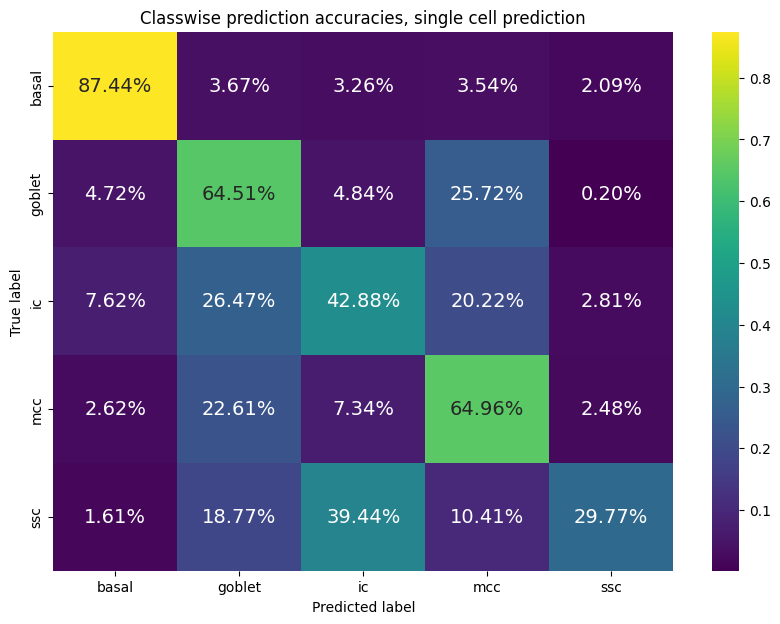

In [254]:
# define independent and dependent variables for the whole dataset
train_independent_variables = train_tracks_df_balanced[['t_hours'] + selected_non_latent]
test_independent_variables = test_tracks_df[['t_hours'] + selected_non_latent]

train_dependent_variables = train_tracks_df_balanced.loc[:, "cell_type"]
test_dependent_variables = test_tracks_df.loc[:, "cell_type"]

#numerically encode classes for classifier
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(train_dependent_variables)
y_test = labelencoder.transform(test_dependent_variables)

# Define your class labels (modify this based on your actual class labels)
class_labels = ['basal', 'goblet', 'ic', 'mcc', 'ssc']  # Example labels

# Step 1: Train your model
model = xgb.XGBClassifier({'objective': 'multi:softprob', 'num_class': 5})
model.fit(train_independent_variables, y_train)

# Step 2: Make predictions
y_pred = model.predict(test_independent_variables)

# Step 3: Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Step 4: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 5: Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 6: Plot the normalized confusion matrix with string class labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Classwise prediction accuracies, single cell prediction')
plt.show()

Oversampling with SMOTE

In [255]:
from imblearn.over_sampling import SMOTENC

def weighted_oversample(df, target_col, stratify_col, bins=10):
    df_encoded = df.copy()
    df_encoded["t_hours_bin"] = pd.qcut(df_encoded[stratify_col], q=bins, duplicates="drop")

    # Encode categorical variables if needed
    label_encoder = LabelEncoder()
    df_encoded[target_col] = label_encoder.fit_transform(df_encoded[target_col])

    # Select features and target
    X = df_encoded[['t_hours', 't_hours_bin'] + selected_non_latent]
    y = df_encoded[target_col]

    # Apply SMOTENC
    smote = SMOTENC(categorical_features=[X.columns.get_loc("t_hours_bin")], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Convert back to DataFrame
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_col] = y_resampled

    df_resampled[target_col] = label_encoder.inverse_transform(df_resampled[target_col])

    return df_resampled.drop(columns=["t_hours_bin"])

# Apply function
train_tracks_df_balanced = weighted_oversample(train_tracks_df, target_col="cell_type", stratify_col="t_hours", bins=10)

In [256]:
train_tracks_df_balanced['cell_type'].value_counts()

mcc       152983
ic        152983
ssc       152983
basal     152983
goblet    152983
Name: cell_type, dtype: int64

In [259]:
cell_type_dict = {'basal' : 0, 'goblet' : 1, 'ic' : 2, 'mcc' : 3, 'ssc' : 4}

c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Accuracy: 0.8940076981832886


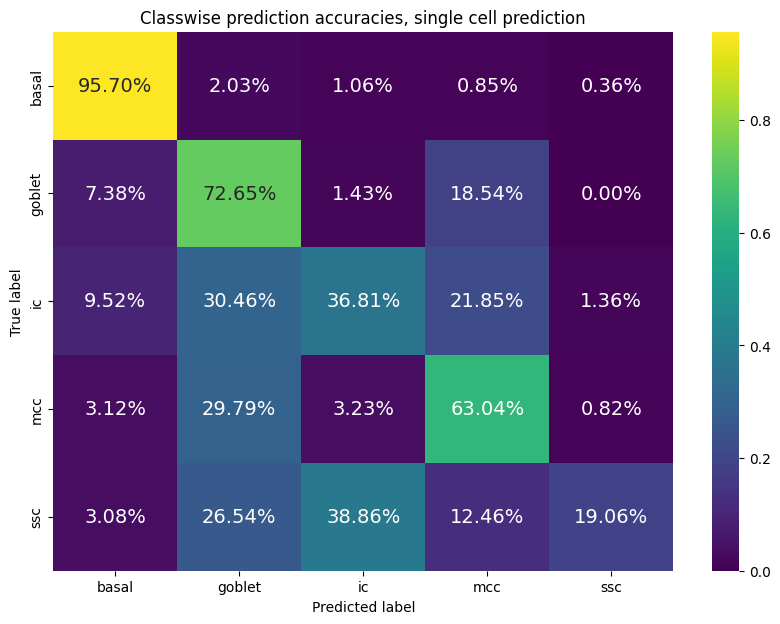

In [260]:
# define independent and dependent variables for the whole dataset
train_independent_variables = train_tracks_df_balanced[['t_hours'] + selected_non_latent]
test_independent_variables = test_tracks_df[['t_hours'] + selected_non_latent]

train_dependent_variables = train_tracks_df_balanced.loc[:, "cell_type"]
test_dependent_variables = test_tracks_df.loc[:, "cell_type"]

#numerically encode classes for classifier
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(train_dependent_variables)
y_test = labelencoder.transform(test_dependent_variables)

# Define your class labels (modify this based on your actual class labels)
class_labels = ['basal', 'goblet', 'ic', 'mcc', 'ssc']  # Example labels

# Step 1: Train your model
model = xgb.XGBClassifier({'objective': 'multi:softprob', 'num_class': 5})
model.fit(train_independent_variables, y_train)

# Step 2: Make predictions
y_pred = model.predict(test_independent_variables)

# Step 3: Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Step 4: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 5: Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 6: Plot the normalized confusion matrix with string class labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Classwise prediction accuracies, single cell prediction')
plt.show()

Combination of undersampling and oversampling  
  
In this case, majority classes are undersampled to correspond to middle sized class (MCC), and minority classes are oversampled using SMOTE

In [215]:
def weighted_undersample_majorityclasses(df, target_class, target_col, stratify_col, bins=10):
    # Bin continuous `t_hours` for stratification
    df["t_hours_bin"] = pd.qcut(df[stratify_col], q=bins, duplicates="drop")

    # Find class sizes
    class_counts = df[target_col].value_counts()
    target_size = class_counts[target_class]  # Smallest class as reference

    # Perform weighted undersampling
    df_resampled = pd.concat([
        df[df[target_col] == c]
        .groupby("t_hours_bin", group_keys=False)
        .apply(lambda x: x.sample(frac=target_size / len(df[df[target_col] == c]))).reset_index(drop=True)
        for c in ['basal', 'goblet', 'mcc']]
    )

    return df_resampled.drop(columns=["t_hours_bin"]), target_size

# Apply function
train_tracks_df_balanced_undersampled, target_class_size = weighted_undersample_majorityclasses(train_tracks_df, target_class = 'mcc', target_col="cell_type", stratify_col="t_hours", bins=10)

def weighted_oversample_minorityclasses(df, target_size, target_col, stratify_col, bins=10):
    df_encoded = df[df[target_col].isin(['ic', 'ssc'])]
    df_encoded["t_hours_bin"] = pd.qcut(df_encoded[stratify_col], q=bins, duplicates="drop")

    # Encode categorical variables if needed
    label_encoder = LabelEncoder()
    df_encoded[target_col] = label_encoder.fit_transform(df_encoded[target_col])

    # Select features and target
    X = df_encoded[['t_hours', 't_hours_bin'] + selected_non_latent]
    y = df_encoded[target_col]

    # Apply SMOTENC
    smote = SMOTENC(categorical_features=[X.columns.get_loc("t_hours_bin")], sampling_strategy={0 : target_size, 1 : target_size}, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Convert back to DataFrame
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_col] = y_resampled

    df_resampled[target_col] = label_encoder.inverse_transform(df_resampled[target_col])

    return df_resampled.drop(columns=["t_hours_bin"])

# Apply function
train_tracks_df_balanced_oversampled = weighted_oversample_minorityclasses(train_tracks_df, target_class_size, target_col="cell_type", stratify_col="t_hours", bins=10)

C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\571633096.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded["t_hours_bin"] = pd.qcut(df_encoded[stratify_col], q=bins, duplicates="drop")
C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\571633096.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[target_col] = label_encoder.fit_transform(df_encoded[target_col])


In [216]:
train_tracks_df_balanced_undersampled['cell_type'].value_counts()

mcc       19762
basal     19761
goblet    19761
Name: cell_type, dtype: int64

In [217]:
train_tracks_df_balanced_oversampled['cell_type'].value_counts()

ic     19762
ssc    19762
Name: cell_type, dtype: int64

In [218]:
train_tracks_df_balanced_undersampled_cropped = train_tracks_df_balanced_undersampled[train_tracks_df_balanced_oversampled.columns]

In [219]:
train_tracks_df_balanced = pd.concat([train_tracks_df_balanced_undersampled_cropped, train_tracks_df_balanced_oversampled])

In [220]:
train_tracks_df_balanced['cell_type'].value_counts()

mcc       19762
ic        19762
ssc       19762
basal     19761
goblet    19761
Name: cell_type, dtype: int64

c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Accuracy: 0.8573428456050612


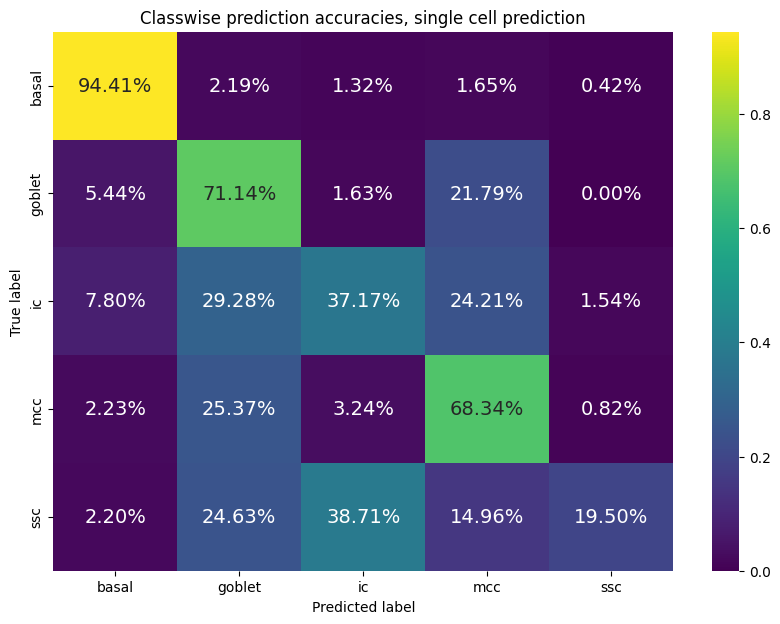

In [222]:
# define independent and dependent variables for the whole dataset
train_independent_variables = train_tracks_df_balanced[['t_hours'] + selected_non_latent]
test_independent_variables = test_tracks_df[['t_hours'] + selected_non_latent]

train_dependent_variables = train_tracks_df_balanced.loc[:, "cell_type"]
test_dependent_variables = test_tracks_df.loc[:, "cell_type"]

#numerically encode classes for classifier
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(train_dependent_variables)
y_test = labelencoder.transform(test_dependent_variables)

# Define your class labels (modify this based on your actual class labels)
class_labels = ['basal', 'goblet', 'ic', 'mcc', 'ssc']  # Example labels

# Step 1: Train your model
model = xgb.XGBClassifier({'objective': 'multi:softprob', 'num_class': 5})
model.fit(train_independent_variables, y_train)

# Step 2: Make predictions
y_pred = model.predict(test_independent_variables)

# Step 3: Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Step 4: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 5: Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 6: Plot the normalized confusion matrix with string class labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Classwise prediction accuracies, single cell prediction')
plt.show()

Not so many performance losses or gains with oversampling + undersampling strategy, but significant time gain --> combination method used for now

### Are the cell types the most different from each other in the experiment end?

As the cells are functionally the most different from each other in the experiment end (cell differentiation is finalized), we normally assume that the cell types also differ the most from each other in the experiment end.  
  
To test this, we first establish how well the classifier works in the experiment end! For this, we use final hour of the experiment.

In [223]:
train_tracks_df = train_tracks_df_balanced

In [224]:
train_tracks_df_final = train_tracks_df[train_tracks_df['t_hours'] > 21]
test_tracks_df_final = test_tracks_df[test_tracks_df['t_hours'] > 21]

In [225]:
# for classification, use all selected features as independent variables and cell types as dependent variable
train_independent_variables_final = train_tracks_df_final[['t_hours'] + selected_non_latent]
test_independent_variables_final = test_tracks_df_final[['t_hours'] + selected_non_latent]

train_dependent_variables_final = train_tracks_df_final.loc[:, "cell_type"]
test_dependent_variables_final = test_tracks_df_final.loc[:, "cell_type"]

In [226]:
# numerically encode dependent variables
labelencoder = LabelEncoder()
y_train_final = labelencoder.fit_transform(train_dependent_variables_final)
y_test_final = labelencoder.transform(test_dependent_variables_final)

Accuracy: 0.8347417840375587


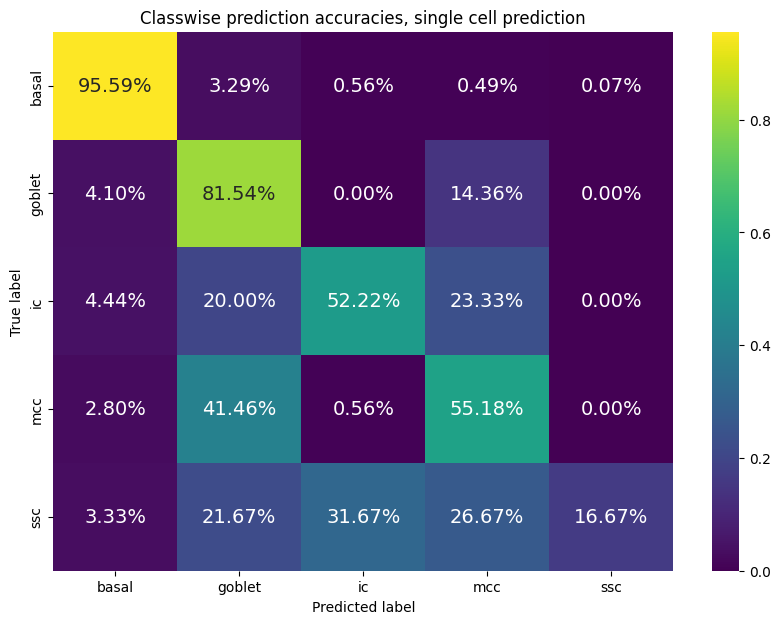

In [228]:
# train a XGBoost classifier with default parameters
model = xgb.XGBClassifier()
model.fit(train_independent_variables_final, y_train_final)

# Define class labels for confusion matrix
class_labels = ['basal', 'goblet', 'ic', 'mcc', 'ssc']  # Example labels

# Make predictions
y_pred_final = model.predict(test_independent_variables_final)

# Calculate the overall accuracy
accuracy = accuracy_score(y_test_final, y_pred_final)
print(f'Accuracy: {accuracy}')

# Compute the confusion matrix
cm = confusion_matrix(y_test_final, y_pred_final)

# Normalize the confusion matrix to show class-wise percentage of predictions, ground truth vs. prediction
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Classwise prediction accuracies, single cell prediction')
plt.show()

### Can prediction be improved by adding more timepoints to the final hour?

In [229]:
# define independent and dependent variables for the whole dataset
train_independent_variables = train_tracks_df[['t_hours'] + selected_non_latent]
test_independent_variables = test_tracks_df[['t_hours'] + selected_non_latent]

train_dependent_variables = train_tracks_df.loc[:, "cell_type"]
test_dependent_variables = test_tracks_df.loc[:, "cell_type"]

Here, I start out with the cell in the final hour as the "base training dataset", and incrementally add more training data from the previous hours. NOTE! While doing this, I also change the testing dataset, so that it matches the training dataset timewise.

In [230]:
if 'prediction' in test_tracks_df.columns:
    test_tracks_df.drop(labels = ['prediction'], axis=1, inplace=True)

# Define the list of all classes
all_classes = labelencoder.classes_

times_incremental = []
total_accuracies_incremental = []
basal_accuracies_incremental = []
goblet_accuracies_incremental = []
ic_accuracies_incremental = []
mcc_accuracies_incremental = []
ssc_accuracies_incremental = []

# the final hour dataset was df t_hours > 21h, 
# define the subset dataframe from which timepoints are added to the final dataframe

subset_train_tracks_df = train_tracks_df[train_tracks_df['t_hours'] <= 21]
subset_test_tracks_df = test_tracks_df[test_tracks_df['t_hours'] <= 21]

for t in tqdm(range(0, 21)):
    times_incremental.append(t)
    
    # Filter data for the current time window
    train_indices = (train_tracks_df['t_hours'] >= 21 - t)
    test_indices = (test_tracks_df['t_hours'] >= 21 - t)

    time_train_independent_variables = pd.concat([train_independent_variables[train_indices],train_independent_variables_final])
    time_test_independent_variables = pd.concat([test_independent_variables[test_indices], test_independent_variables_final])
    time_train_dependent_variables = pd.concat([train_dependent_variables[train_indices], train_dependent_variables_final])
    time_test_dependent_variables = pd.concat([test_dependent_variables[test_indices], test_dependent_variables_final])



    # Encode only the classes present in this time window
    window_labelencoder = LabelEncoder()
    y_train = window_labelencoder.fit_transform(time_train_dependent_variables)
    y_test = window_labelencoder.transform(time_test_dependent_variables)

    # Define the model with the specific number of classes for this window
    model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(window_labelencoder.classes_))
    model.fit(time_train_independent_variables, y_train)

    # Make predictions
    y_pred = model.predict(time_test_independent_variables)

    # Calculate the accuracy for this time window
    accuracy = accuracy_score(y_test, y_pred)
    total_accuracies_incremental.append(accuracy)

    # Compute the confusion matrix for the current classes and normalize
    cm = confusion_matrix(y_test, y_pred, labels=range(len(window_labelencoder.classes_)))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Map per-class accuracies based on label names in `all_classes`
    for i, class_name in enumerate(all_classes):
        if class_name in window_labelencoder.classes_:
            class_index = list(window_labelencoder.classes_).index(class_name)
            class_accuracy = cm_normalized[class_index, class_index]
        else:
            class_accuracy = 0  # Class not present in this window

        if class_name == 'basal':
            basal_accuracies_incremental.append(class_accuracy)
        elif class_name == 'goblet':
            goblet_accuracies_incremental.append(class_accuracy)
        elif class_name == 'ic':
            ic_accuracies_incremental.append(class_accuracy)
        elif class_name == 'mcc':
            mcc_accuracies_incremental.append(class_accuracy)
        elif class_name == 'ssc':
            ssc_accuracies_incremental.append(class_accuracy)

100%|██████████| 21/21 [01:27<00:00,  4.18s/it]


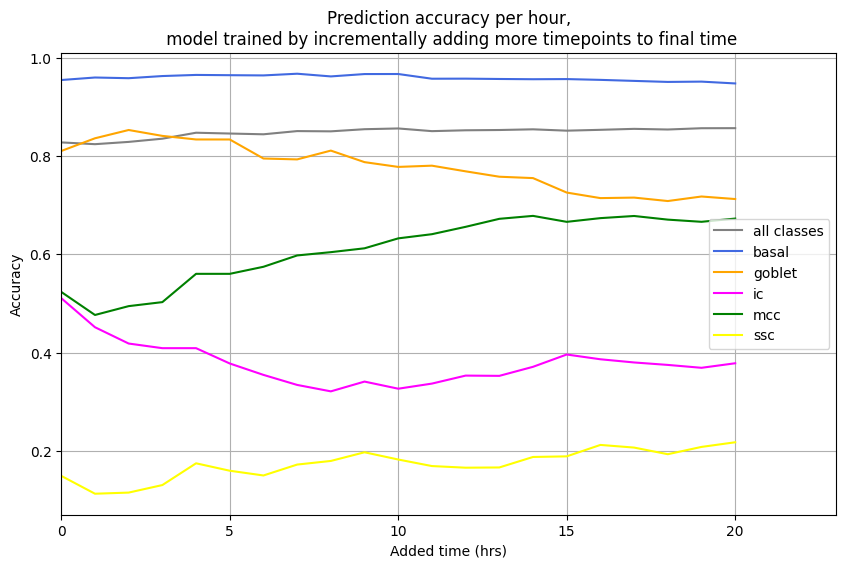

In [231]:
predictions_df = pd.DataFrame({
    't_hours': times_incremental,     # This will be the x-axis variable
    'total_acc': total_accuracies_incremental,    # These will be the y-axis variables
    'basal_acc': basal_accuracies_incremental,
    'goblet_acc': goblet_accuracies_incremental,
    'ic_acc': ic_accuracies_incremental,
    'mcc_acc': mcc_accuracies_incremental,
    'ssc_acc': ssc_accuracies_incremental,
})

plt.figure(figsize=(10, 6))

# Plot each Y-column against X
columns = ['total_acc', 'basal_acc', 'goblet_acc', 'ic_acc', 'mcc_acc', 'ssc_acc']
labels_dict = {'total_acc' : 'all classes', 'basal_acc' : 'basal', 'goblet_acc' : 'goblet', 'ic_acc' : 'ic', 'mcc_acc' : 'mcc', 'ssc_acc' : 'ssc'}
colors_dict = {'total_acc' : 'gray', 'basal_acc' : 'royalblue', 'goblet_acc' : 'orange', 'ic_acc' : 'magenta', 'mcc_acc' : 'green', 'ssc_acc' : 'yellow'}

for y_column in columns:
    plt.plot(predictions_df['t_hours'], predictions_df[y_column], label=labels_dict[y_column], color=colors_dict[y_column])

# Customize the plot
plt.xlabel('Added time (hrs)')
plt.ylabel('Accuracy')
plt.title('Prediction accuracy per hour,\n model trained by incrementally adding more timepoints to final time')
plt.xlim(0,23)
plt.legend()
plt.grid(True)
plt.show()

Adding even all of the experimental time to the final timepoint does not significantly reduce prediction accuracy. In fact, MCC prediction accuracy is improved with increased time sampling.

What about a model trained separately for every hour?

In [232]:
if 'prediction' in test_tracks_df.columns:
    test_tracks_df.drop(labels = ['prediction'], axis=1, inplace=True)

train_independent_variables = train_tracks_df[['t_hours'] + selected_non_latent]
test_independent_variables = test_tracks_df[['t_hours'] + selected_non_latent]

train_dependent_variables = train_tracks_df.loc[:, "cell_type"]
test_dependent_variables = test_tracks_df.loc[:, "cell_type"]

labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(train_dependent_variables)
y_test = labelencoder.transform(test_dependent_variables)

# Define the list of all classes
all_classes = labelencoder.classes_

times = []
total_accuracies = []
basal_accuracies = []
goblet_accuracies = []
ic_accuracies = []
mcc_accuracies = []
ssc_accuracies = []

for t in tqdm(range(0, 23, 2)):
    times.append(t)
    
    # Filter data for the current time window
    train_indices = (train_tracks_df['t_hours'] >= t) & (train_tracks_df['t_hours'] < t + 2)
    test_indices = (test_tracks_df['t_hours'] >= t) & (test_tracks_df['t_hours'] < t + 2)
    time_train_independent_variables = train_independent_variables[train_indices]
    time_test_independent_variables = test_independent_variables[test_indices]
    
    time_train_dependent_variables = train_dependent_variables[train_indices]
    time_test_dependent_variables = test_dependent_variables[test_indices]

    # Encode only the classes present in this time window
    window_labelencoder = LabelEncoder()
    y_train = window_labelencoder.fit_transform(time_train_dependent_variables)
    y_test = window_labelencoder.transform(time_test_dependent_variables)

    # Define the model with the specific number of classes for this window
    model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(window_labelencoder.classes_))
    model.fit(time_train_independent_variables, y_train)

    # Make predictions
    y_pred = model.predict(time_test_independent_variables)

    # Calculate the accuracy for this time window
    accuracy = accuracy_score(y_test, y_pred)
    total_accuracies.append(accuracy)

    # Compute the confusion matrix for the current classes and normalize
    cm = confusion_matrix(y_test, y_pred, labels=range(len(window_labelencoder.classes_)))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Map per-class accuracies based on label names in `all_classes`
    for i, class_name in enumerate(all_classes):
        if class_name in window_labelencoder.classes_:
            class_index = list(window_labelencoder.classes_).index(class_name)
            class_accuracy = cm_normalized[class_index, class_index]
        else:
            class_accuracy = 0  # Class not present in this window

        if class_name == 'basal':
            basal_accuracies.append(class_accuracy)
        elif class_name == 'goblet':
            goblet_accuracies.append(class_accuracy)
        elif class_name == 'ic':
            ic_accuracies.append(class_accuracy)
        elif class_name == 'mcc':
            mcc_accuracies.append(class_accuracy)
        elif class_name == 'ssc':
            ssc_accuracies.append(class_accuracy)

  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1238984773.py:55: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
  8%|▊         | 1/12 [00:00<00:08,  1.27it/s]C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1238984773.py:55: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


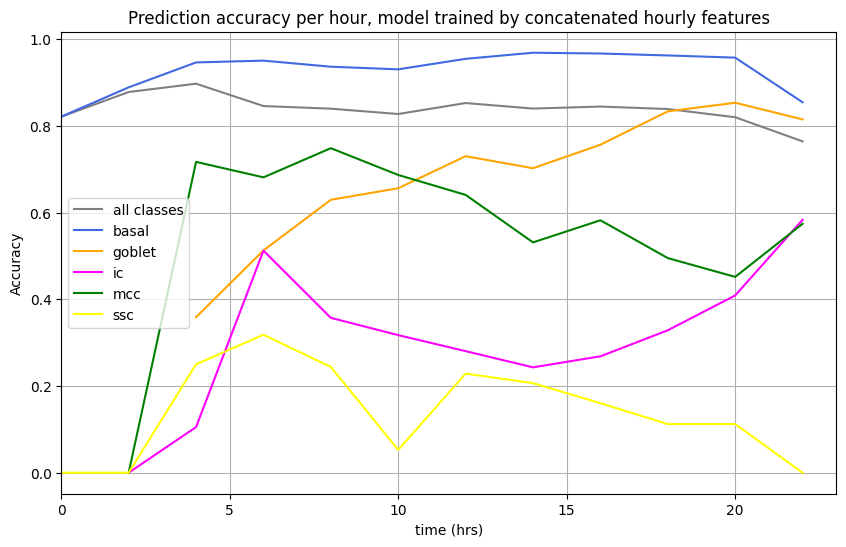

In [233]:
predictions_df = pd.DataFrame({
    't_hours': times,     # This will be the x-axis variable
    'total_acc': total_accuracies,    # These will be the y-axis variables
    'basal_acc': basal_accuracies,
    'goblet_acc': goblet_accuracies,
    'ic_acc': ic_accuracies,
    'mcc_acc': mcc_accuracies,
    'ssc_acc': ssc_accuracies,
})

plt.figure(figsize=(10, 6))

# Plot each Y-column against X
columns = ['total_acc', 'basal_acc', 'goblet_acc', 'ic_acc', 'mcc_acc', 'ssc_acc']
labels_dict = {'total_acc' : 'all classes', 'basal_acc' : 'basal', 'goblet_acc' : 'goblet', 'ic_acc' : 'ic', 'mcc_acc' : 'mcc', 'ssc_acc' : 'ssc'}
colors_dict = {'total_acc' : 'gray', 'basal_acc' : 'royalblue', 'goblet_acc' : 'orange', 'ic_acc' : 'magenta', 'mcc_acc' : 'green', 'ssc_acc' : 'yellow'}

for y_column in columns:
    plt.plot(predictions_df['t_hours'], predictions_df[y_column], label=labels_dict[y_column], color=colors_dict[y_column])

# Customize the plot
plt.xlabel('time (hrs)')
plt.ylabel('Accuracy')
plt.title('Prediction accuracy per hour, model trained by concatenated hourly features')
plt.xlim(0,23)
plt.legend()
plt.grid(True)
plt.show()

Separate models doesn't seem to be the way to go -- probably because sample size is too small to split the train dataset into smaller chunks

Visualising classwise feature distances across time -- do the features classwise distance increase over time? Calculate the distance of each cell's features to classwise feature centroid, across binned time

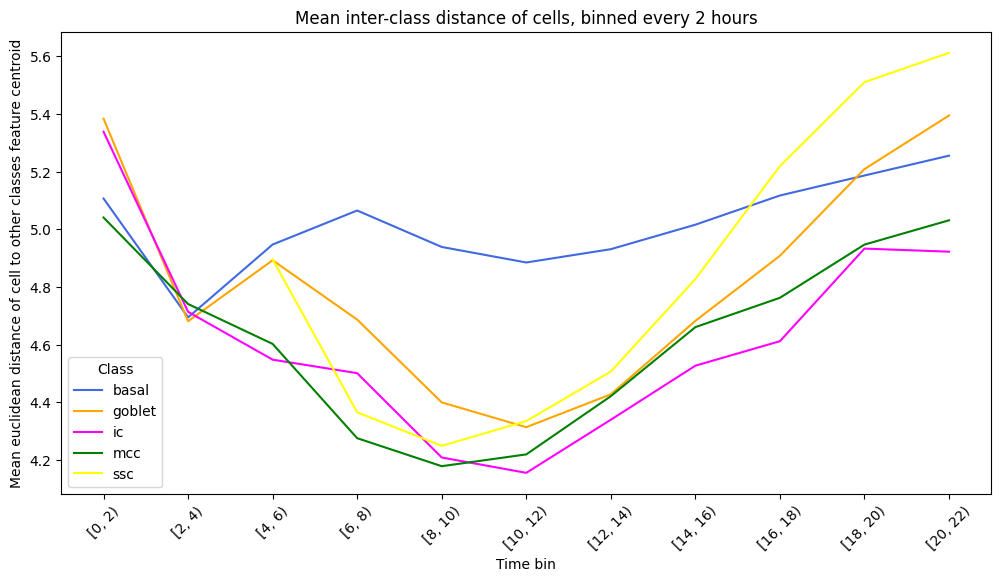

In [234]:
colors_dict = {'basal' : 'royalblue', 'goblet' : 'orange', 'ic' : 'magenta', 'mcc' : 'green', 'ssc' : 'yellow'}

from scipy.spatial.distance import cdist

def plot_inter_class_distances(df, features, target_col, time_col):
    # Define time bins at whole hours (0-23)
    bin_edges = np.arange(0, 24, 2)  # Bins from 0 to 23 in 1-hour steps
    df["t_bin"] = pd.cut(df[time_col], bins=bin_edges, include_lowest=True, right=False)  # Left-inclusive bins

    results = []

    for t_bin, group in df.groupby("t_bin"):
        centroids = group.groupby(target_col)[features].mean()  # Compute feature centroids for each class

        for class_label, class_group in group.groupby(target_col):
            if len(class_group) < 2:
                continue  # Skip classes with only one sample in the bin

            X_class = class_group[features]  # Features for this class

            # Compute inter-class distances (distance to all other class centroids)
            other_classes = centroids.drop(index=class_label, errors="ignore")
            if not other_classes.empty:
                inter_distances = cdist(X_class, other_classes, metric="euclidean")  # Distances to other centroids
                mean_inter_distance = np.mean(inter_distances)
            else:
                mean_inter_distance = np.nan

            results.append({"Time Bin": str(t_bin), "Class": class_label, "Mean Inter-Class Distance": mean_inter_distance})

    # Convert to DataFrame
    distance_df = pd.DataFrame(results)

    # Plot each class as a separate line
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=distance_df, x="Time Bin", y="Mean Inter-Class Distance", hue="Class", palette=colors_dict)
    plt.xticks(rotation=45)
    plt.title("Mean inter-class distance of cells, binned every 2 hours")
    plt.xlabel("Time bin")
    plt.ylabel("Mean euclidean distance of cell to other classes feature centroid")
    plt.legend(title="Class")
    plt.show()

# Usage
plot_inter_class_distances(train_df2, features=selected_non_latent, target_col="cell_type", time_col="t_hours")


Feature distance of classes increases across time, but is this just due to cell diversification? Estimate the ratio of inter-class feature distance to intra-class feautre distance!

100%|██████████| 11/11 [00:00<00:00, 22.73it/s]


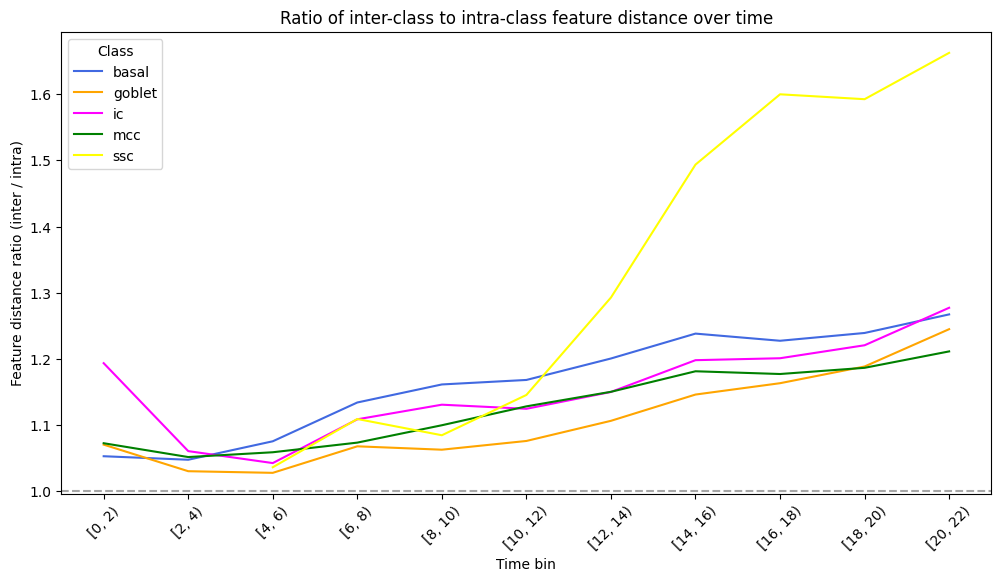

In [235]:
def plot_distance_ratios(df, features, target_col, time_col, bins=10):
    # Define time bins at whole hours (0-23)
    bin_edges = np.arange(0, 24, 2)  # Bins from 0 to 23 in 1-hour steps
    df["t_bin"] = pd.cut(df[time_col], bins=bin_edges, include_lowest=True, right=False)  # Left-inclusive bins

    results = []

    for t_bin, group in tqdm(df.groupby("t_bin")):
        centroids = group.groupby(target_col)[features].mean()  # Compute feature centroids for each class

        for class_label, class_group in group.groupby(target_col):
            if len(class_group) < 2:
                continue  # Skip classes with only one sample in the bin

            X_class = class_group[features]  # Features for this class
            class_centroid = centroids.loc[class_label].values.reshape(1, -1)  # Centroid of this class

            # Compute intra-class distances (distance to own class centroid)
            intra_distances = cdist(X_class, class_centroid, metric="euclidean").flatten()
            mean_intra_distance = np.mean(intra_distances) if len(intra_distances) > 0 else np.nan

            # Compute inter-class distances (distance to all other class centroids)
            other_classes = centroids.drop(index=class_label, errors="ignore")
            if not other_classes.empty:
                inter_distances = cdist(X_class, other_classes, metric="euclidean")  # Distances to other centroids
                mean_inter_distance = np.mean(inter_distances)
            else:
                mean_inter_distance = np.nan

            # Compute ratio
            distance_ratio = mean_inter_distance / mean_intra_distance if mean_intra_distance > 0 else np.nan

            results.append({"Time Bin": str(t_bin), "Class": class_label, "Distance Ratio": distance_ratio})

    # Convert to DataFrame
    distance_df = pd.DataFrame(results)

    # Plot each class as a separate line
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=distance_df, x="Time Bin", y="Distance Ratio", hue="Class", palette=colors_dict)
    plt.xticks(rotation=45)
    plt.title("Ratio of inter-class to intra-class feature distance over time")
    plt.xlabel("Time bin")
    plt.ylabel("Feature distance ratio (inter / intra)")
    plt.legend(title="Class")
    plt.axhline(y=1, linestyle="--", color="gray", alpha=0.7)  # Baseline where inter-class = intra-class
    plt.show()

# Usage
plot_distance_ratios(train_df2, features=selected_non_latent, target_col="cell_type", time_col="t_hours", bins=20)


It seems that mostly, cells diversify overall, thus, the ratio of inter-class distance/intra-class distance doesn't increase as much (around 1.25 at the highest) except for the minority class of SSCs. Thus, there's no big incentive to prefer final timepoints for training the classifier, when the training dataset is already rather small!

Lastly, does confidence of predictions increase in time when the model is trained with all timepoints?

In [236]:
#Train model using all timepoints

labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(train_dependent_variables)
y_test = labelencoder.transform(test_dependent_variables)

model = xgb.XGBClassifier()
model.fit(train_independent_variables, y_train)
y_pred = model.predict(test_independent_variables)
accuracy = metrics.accuracy_score(y_pred, y_test)
print(f'Overall accuracy: {accuracy}')

Overall accuracy: 0.8573428456050612


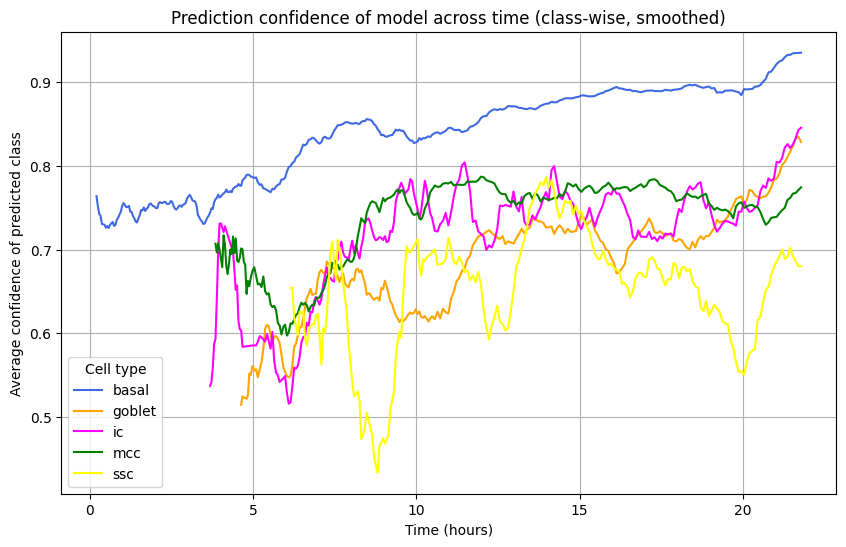

In [237]:
# Get predicted probabilities
y_pred_proba = model.predict_proba(test_independent_variables)

# Extract the highest confidence score for each prediction
test_tracks_df['prediction_confidence'] = y_pred_proba.max(axis=1)  # Max probability for predicted class

# Compute average confidence per t_hours and cell_type
confidence_df = (
    test_tracks_df.groupby(['t_hours', 'cell_type'])
    .agg(avg_confidence=('prediction_confidence', 'mean'))
    .reset_index()
)

# Step 4: Apply moving average smoothing across time to see the timewise trend better
window_size = 10  # Adjust for smoothness
plt.figure(figsize=(10, 6))

for cell_type, group_df in confidence_df.groupby('cell_type'):
    # Ensure sorted order by time
    group_df = group_df.sort_values('t_hours')
    
    # Apply rolling mean for smoothing
    group_df['smoothed_confidence'] = group_df['avg_confidence'].rolling(window=window_size, center=True).mean()
    
    # Plot the smoothed confidence scores
    plt.plot(group_df['t_hours'], group_df['smoothed_confidence'], label=cell_type, color=colors_dict[cell_type])

# Adding labels and legend
plt.xlabel('Time (hours)')
plt.ylabel('Average confidence of predicted class')
plt.title('Prediction confidence of model across time (class-wise, smoothed)')
plt.legend(title='Cell type', loc='lower left')
plt.grid(True)
plt.show()


### Working with the classifier using all timepoints

Accuracy: 0.8573428456050612


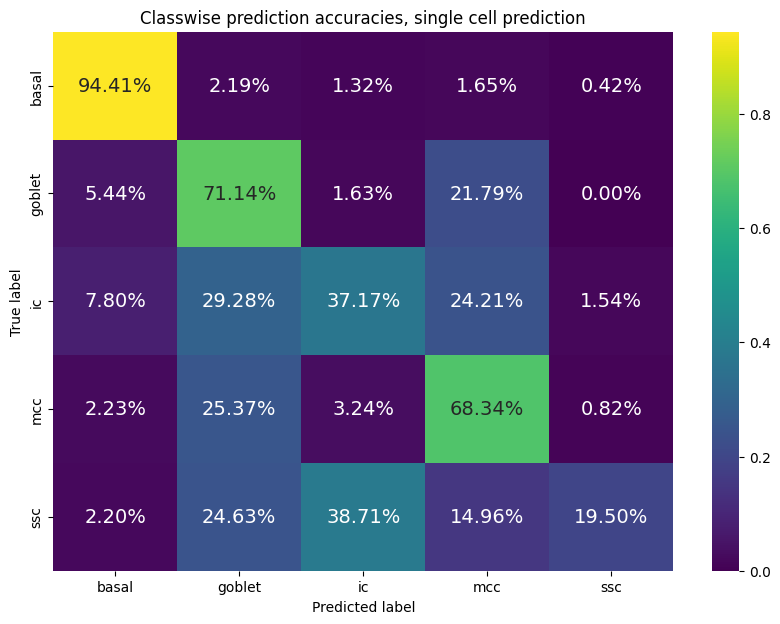

In [ ]:
# Define class labels
class_labels = ['basal', 'goblet', 'ic', 'mcc', 'ssc']  # Example labels

#Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

#Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#Plot the normalized confusion matrix with string class labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Classwise prediction accuracies, single cell prediction')
plt.show()

In [184]:
class_map = {0 : 'basal', 1 : 'goblet', 2 : 'ic', 3 : 'mcc', 4 : 'ssc'}

In [185]:
#numerical encoded prediction label to column in the test df
test_tracks_df['prediction'] = y_pred

#numerical prediction to string 
test_tracks_df['prediction_label'] = test_tracks_df['prediction'].map(class_map)

How does the model perform timewise? Plot accuracy of predictions across time

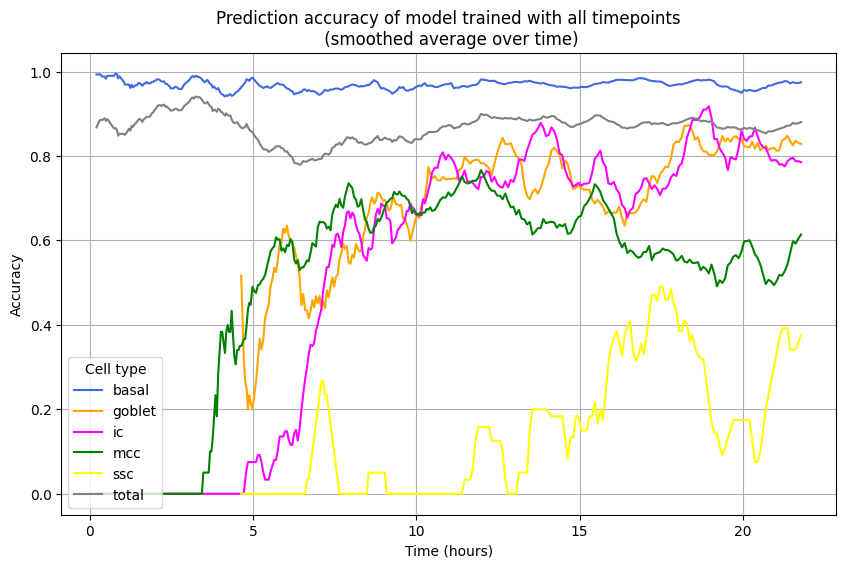

In [186]:
# Create a new column for correct predictions
test_tracks_df['is_correct'] = test_tracks_df['cell_type'] == test_tracks_df['prediction_label']

# Calculate accuracy per t_hours and cell_type
accuracy_df = (
    test_tracks_df.groupby(['t_hours', 'cell_type'])
    .agg(accuracy=('is_correct', 'mean'))
    .reset_index()
)

# Calculate total accuracy per t_hours (for overall line)
total_accuracy_df = (
    test_tracks_df.groupby('t_hours')
    .agg(total_accuracy=('is_correct', 'mean'))
    .reset_index()
)

#Applying some smoothing to make more sense of the timewise development
# Define the moving average window size
window_size = 10  # Adjust this to control the smoothness (higher = smoother)

colors_dict = {'basal' : 'royalblue', 'goblet' : 'orange', 'ic' : 'magenta', 'mcc' : 'green', 'ssc' : 'yellow'}

# Plot with smoothing
plt.figure(figsize=(10, 6))
for cell_type, group_df in accuracy_df.groupby('cell_type'):
    # Apply moving average to the accuracy column
    group_df = group_df.sort_values('t_hours')  # Ensure sorted order by time
    group_df['smoothed_accuracy'] = group_df['accuracy'].rolling(window=window_size, center=True).mean()
    
    # Plot the smoothed line
    plt.plot(group_df['t_hours'], group_df['smoothed_accuracy'], label=cell_type, color=colors_dict[cell_type])

# Plot the overall accuracy line with smoothing
total_accuracy_df = total_accuracy_df.sort_values('t_hours')
total_accuracy_df['smoothed_total_accuracy'] = total_accuracy_df['total_accuracy'].rolling(window=window_size, center=True).mean()
plt.plot(total_accuracy_df['t_hours'], total_accuracy_df['smoothed_total_accuracy'], label='total', color='gray', linewidth=1.5)

# Adding labels and legend
plt.xlabel('Time (hours)')
plt.ylabel('Accuracy')
plt.title('Prediction accuracy of model trained with all timepoints\n (smoothed average over time)')
plt.legend(title='Cell type', loc='lower left')
plt.grid(True)
plt.show()

No clear trends visible except goblet accuracy improving over time...

Are the correct predictions evenly distributed between tracks? Plot predictions per track across time

In [187]:
# Convert Tracklet ID to a categorical type and map to numeric values for plotting
def convert_tracklet_to_numeric(df):
    df['Tracklet ID'] = df['Track ID_y'].astype('category')  # Convert to categorical
    df['Tracklet Numeric'] = df['Tracklet ID'].cat.codes      # Convert to numeric
    return df

# Helper function to plot each tracklet with colored segments based on class
def plot_colored_lines(df, ax, label_column, palette):
    for tracklet_id, tracklet_numeric in zip(df['Tracklet ID'].unique(), df['Tracklet Numeric'].unique()):
        # Extract the data for the current tracklet
        tracklet_data = df[df['Tracklet ID'] == tracklet_id]

        # Iterate over timepoints and plot line segments with corresponding color
        for i in range(len(tracklet_data) - 1):
            t_values = tracklet_data['t_hours'].iloc[i:i+2]
            y_value = tracklet_numeric  # Horizontal line on y-axis (Tracklet Numeric)
            
            # Get the color for this segment based on prediction class
            class_label = tracklet_data[label_column].iloc[i]
            color = palette[class_label]
            
            # Plot the segment as a horizontal line with the corresponding color
            ax.plot(t_values, [y_value, y_value], color=color, linewidth=4)

# Updated plotting function
def plot_predictions(df, celltype):
    fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharex=True)

    # Define a color palette for the shape and dynamic predictions
    palette_pred = {'basal': 'blue', 'goblet': 'orange', 'mcc': 'green', 'ic' : 'magenta', 'ssc' : 'yellow', 'unknown' : 'gray'} 

    # Plot shape predictions with colored segments
    plot_colored_lines(df, axes, 'prediction_label', palette_pred)  # `axes` instead of `axes[0]`
    axes.set_title(f'Morphodynamic Predictions Over Time, celltype: {celltype}')
    axes.set_ylabel('Tracklet ID')
    axes.set_xlabel('Time (t)')

    # Add legends manually for each plot
    handles_morpho = [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in palette_pred.items()]
   
    axes.legend(handles=handles_morpho, bbox_to_anchor=(1.05, 1), loc='upper left', title='Predictions per track')

    plt.tight_layout()
    plt.show()

C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet ID'] = df['Track ID_y'].astype('category')  # Convert to categorical
C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet Numeric'] = df['Tracklet ID'].cat.codes      # Convert to numeric


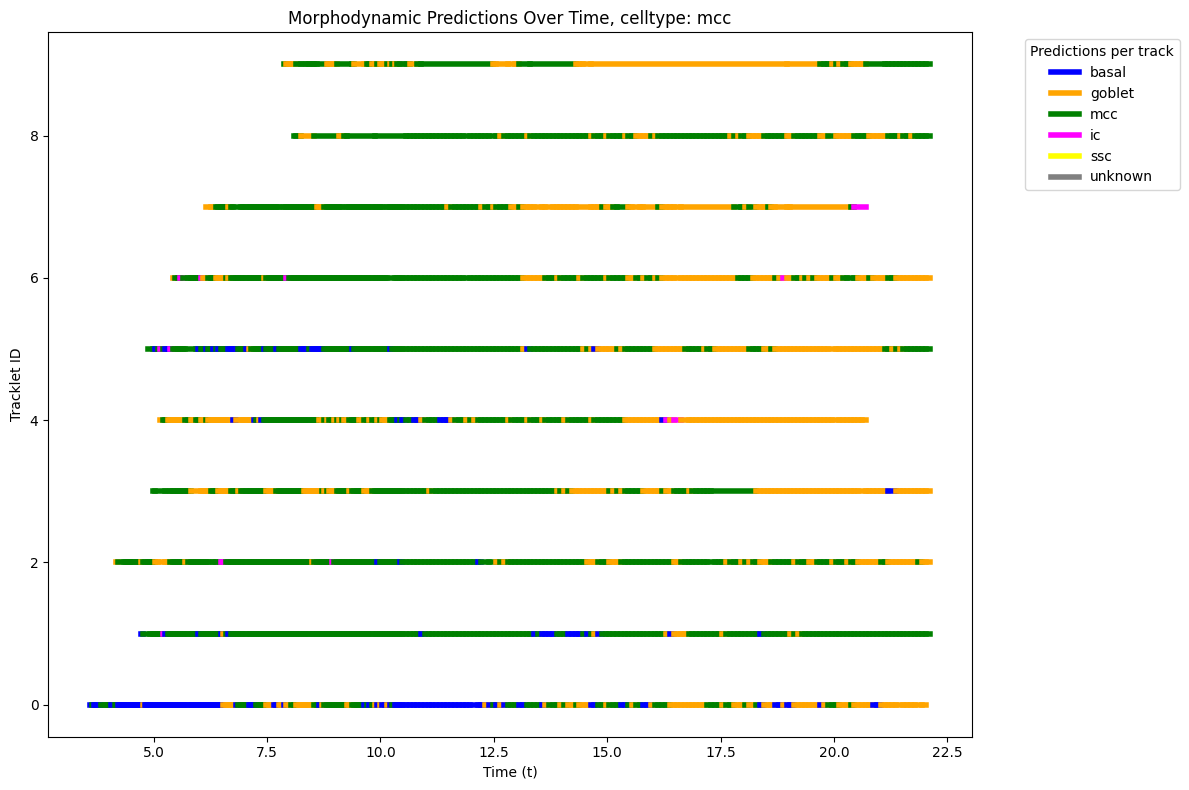

C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet ID'] = df['Track ID_y'].astype('category')  # Convert to categorical
C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet Numeric'] = df['Tracklet ID'].cat.codes      # Convert to numeric


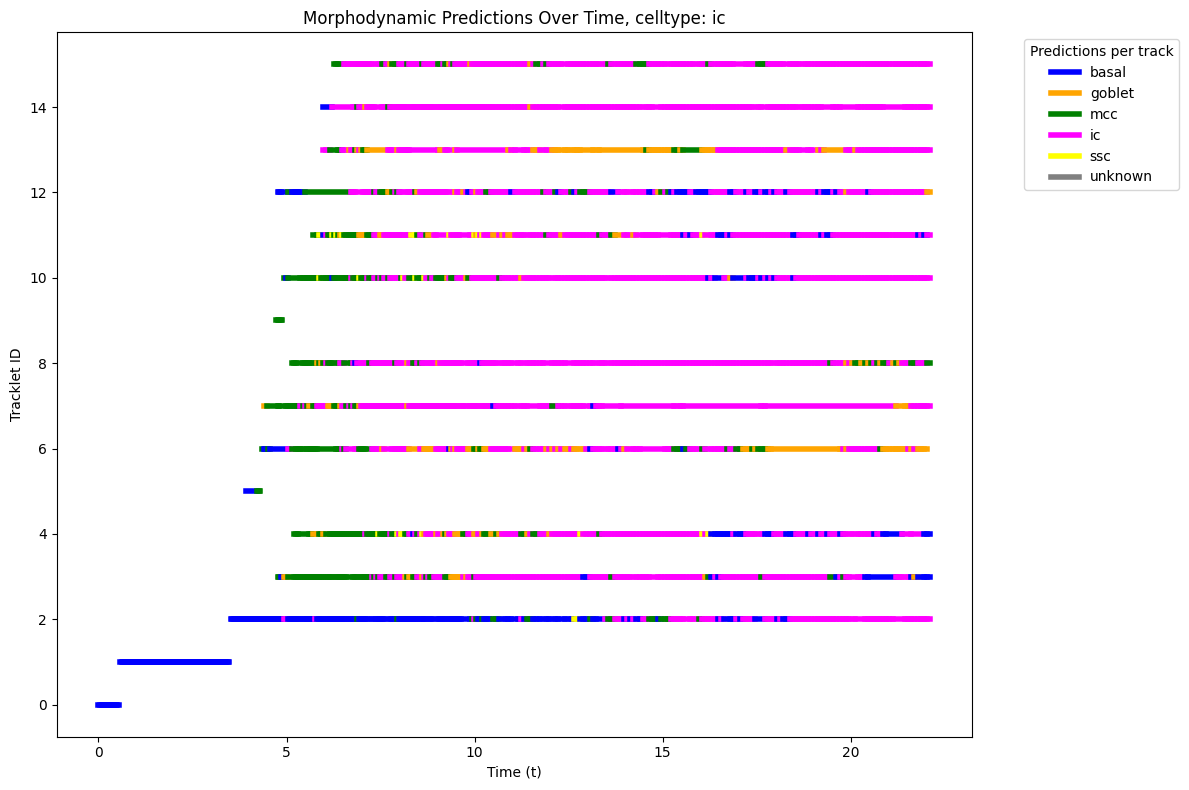

C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet ID'] = df['Track ID_y'].astype('category')  # Convert to categorical
C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet Numeric'] = df['Tracklet ID'].cat.codes      # Convert to numeric


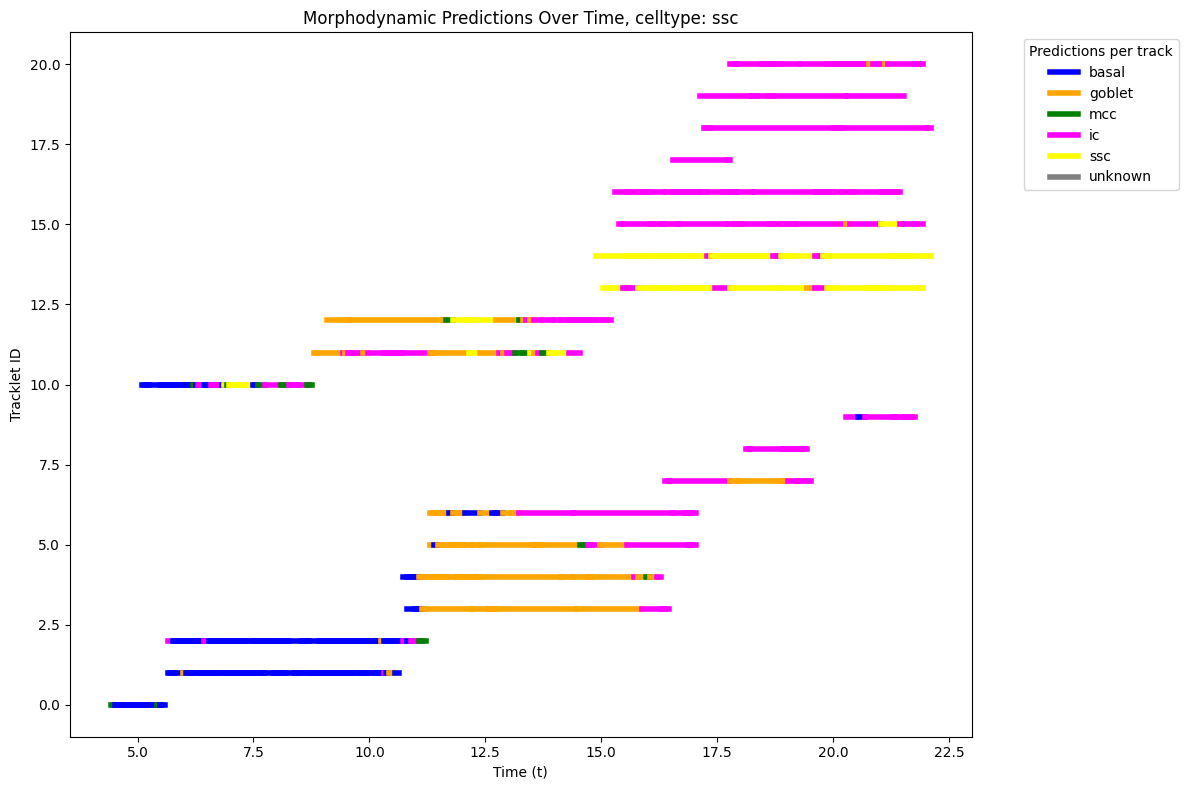

C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet ID'] = df['Track ID_y'].astype('category')  # Convert to categorical
C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet Numeric'] = df['Tracklet ID'].cat.codes      # Convert to numeric


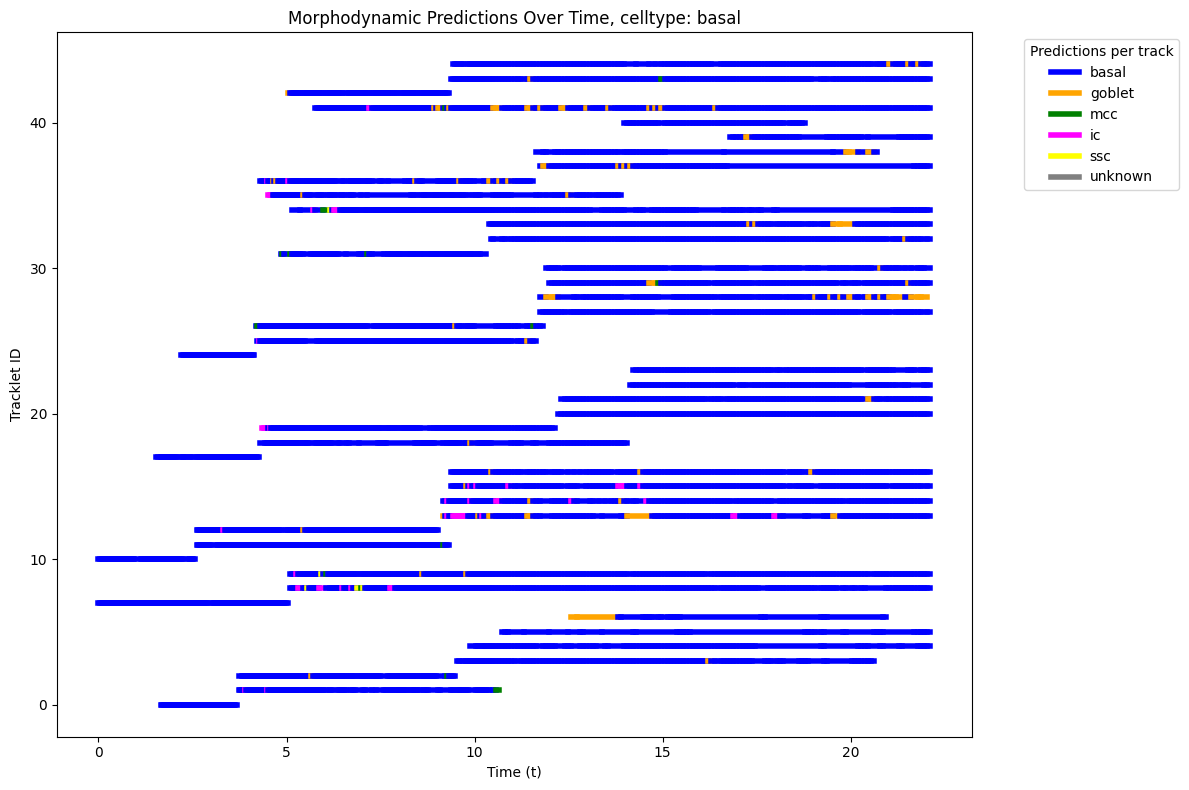

C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet ID'] = df['Track ID_y'].astype('category')  # Convert to categorical
C:\Users\ghr283\AppData\Local\Temp\ipykernel_3156\1934006162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tracklet Numeric'] = df['Tracklet ID'].cat.codes      # Convert to numeric


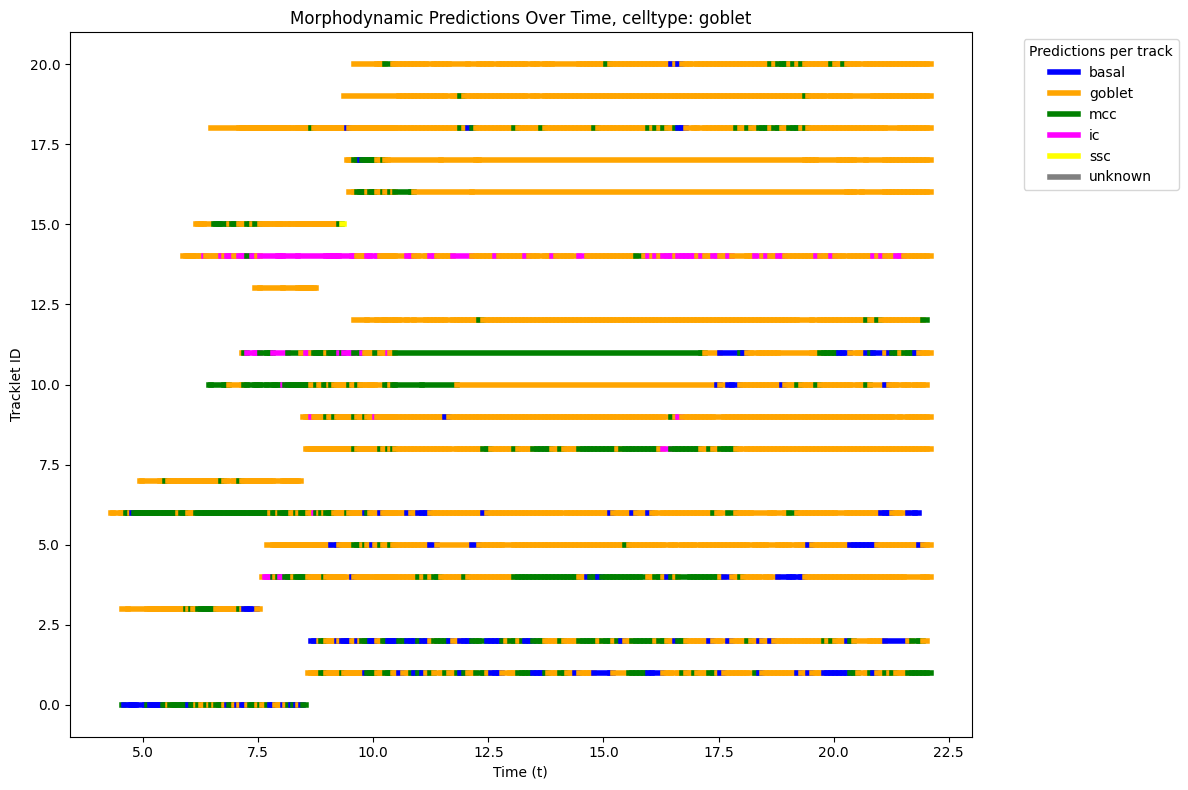

In [188]:
for celltype in test_tracks_df['cell_type'].unique():
    # Convert the unique TrackMate Track ID values to a list before sampling
    celltype_ids = test_tracks_df[test_tracks_df['cell_type'] == celltype]['Spot track ID relabelled'].unique()
    celltype_ids_to_plot = random.sample(list(celltype_ids), min(10, len(celltype_ids)))

    celltype_df = test_tracks_df[test_tracks_df['Spot track ID relabelled'].isin(celltype_ids_to_plot)]

    # Convert Tracklet ID to numeric for plotting
    celltype_df = convert_tracklet_to_numeric(celltype_df)

    plot_predictions(celltype_df, celltype)

For most tracks, it looks like overall the prediction is correct when you apply the most prevalent class per track. Let's reassign the prediction for single cells to a trackwise overall prediction by taking the most frequent prediction label per track.

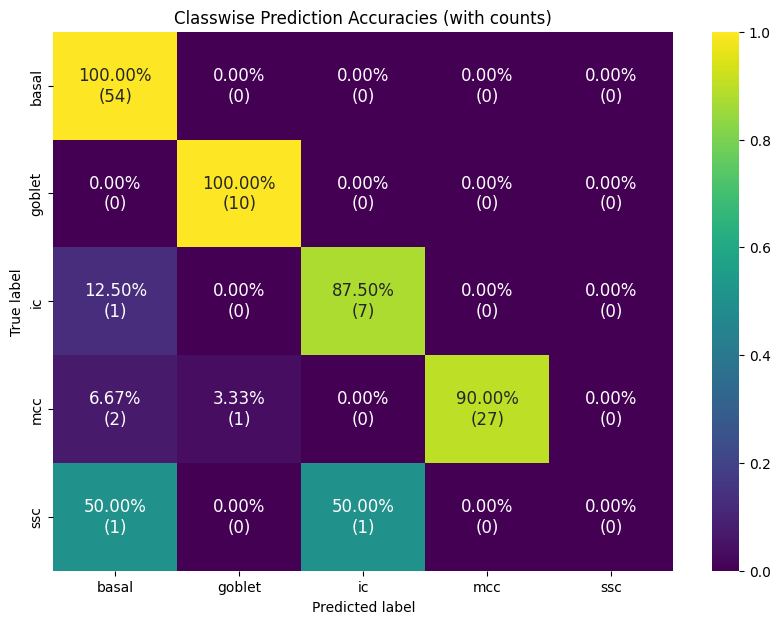

In [189]:
# Step 1: Group by Track ID and get the most prevalent ground truth and prediction for each track
def most_frequent_label(labels):
    counts = labels.value_counts()
    if counts.index[0] == "unknown" and len(counts) > 1:
        return counts.index[1]  # Return the second most frequent label
    return counts.index[0]  # Return the most frequent label

track_summary = test_tracks_df.groupby('Spot track ID relabelled').agg({
    'cell_type': most_frequent_label,
    'prediction_label': most_frequent_label
}).reset_index()

# Step 1: Calculate the confusion matrix
cm = confusion_matrix(track_summary['cell_type'], track_summary['prediction_label'])

# Step 2: Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 3: Define the class labels based on unique labels in the data
class_labels = np.unique(track_summary['cell_type'])

# Step 4: Prepare the annotation text with both percentage and count
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_normalized[i, j] * 100  # Convert to percentage
        annot[i, j] = f"{percent:.2f}%\n({count})"

# Step 5: Plot the confusion matrix with custom annotations
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm_normalized, 
    annot=annot, 
    fmt='',  # Disable default formatting
    cmap='viridis', 
    xticklabels=class_labels, 
    yticklabels=class_labels, 
    annot_kws={"size": 12}
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Classwise Prediction Accuracies (with counts)')
plt.show()

However, the above trackwise prediction is "cheating" a bit, because it is reliant on the manually curated tracking. Therefor it doesn't fully represent how well a fully automated pipeline would predict on tracks. So, I want to also check how making the trackwise prediction based on automated tracks would perform.

In [195]:
track_summary_auto = test_tracks_df.groupby('Spot track ID relabelled_auto').agg({
    'prediction_label': most_frequent_label
}).reset_index()

# Convert to dictionary
pred_dict = dict(zip(track_summary_auto['Spot track ID relabelled_auto'], track_summary_auto['prediction_label']))

In [197]:
test_tracks_df['prediction_trackwise'] = test_tracks_df['Spot track ID relabelled_auto'].map(pred_dict)

To be able to compare cell type of manually annotated tracks vs. automated tracks, which don't correspond to each other in their id, we calculate the overall accuracy by comparing single cell ground truth and single-cell trackwise assigned prediction

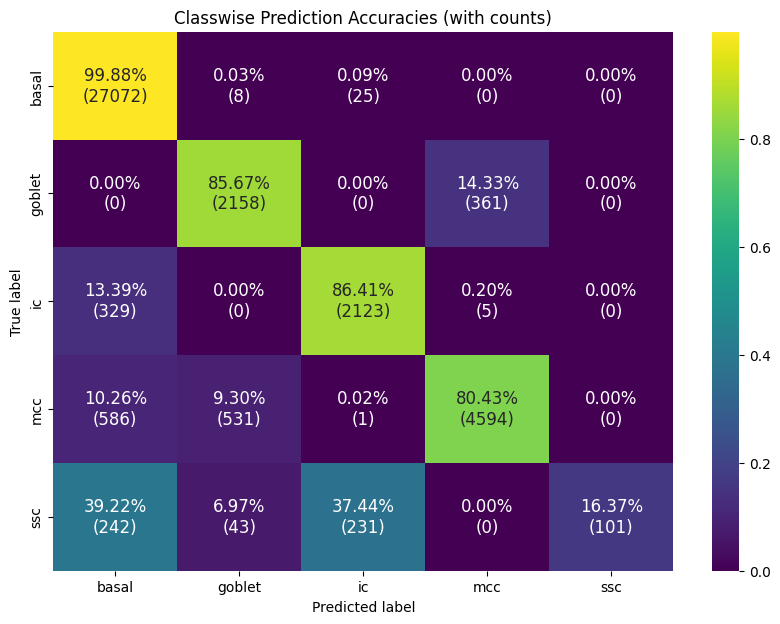

In [200]:
# Step 1: Calculate the confusion matrix
cm = confusion_matrix(test_tracks_df['cell_type'], test_tracks_df['prediction_trackwise'])

# Step 2: Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 3: Define the class labels based on unique labels in the data
class_labels = np.unique(track_summary['cell_type'])

# Step 4: Prepare the annotation text with both percentage and count
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_normalized[i, j] * 100  # Convert to percentage
        annot[i, j] = f"{percent:.2f}%\n({count})"

# Step 5: Plot the confusion matrix with custom annotations
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm_normalized, 
    annot=annot, 
    fmt='',  # Disable default formatting
    cmap='viridis', 
    xticklabels=class_labels, 
    yticklabels=class_labels, 
    annot_kws={"size": 12}
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Classwise Prediction Accuracies (with counts)')
plt.show()

Thus, assigning a prediction for a whole track imporoves prediction of all classes except SSC :)